In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import pickle
import numpy as np
from text_processing_utils import *
import glob
import math
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [3]:
cleaned_ratings = np.array(pickle.load(open("/content/drive/MyDrive/data/scaledata/cleaned_ratings.pickle", "rb")))
cleaned_reviews = pickle.load(open("/content/drive/MyDrive/data/scaledata/cleaned_reviews.pickle", "rb"))
vocabulary_dict = pickle.load(open("/content/drive/MyDrive/data/scaledata/vocabulary_dict.pickle", "rb"))

In [4]:
# randomly split the movie reviews data into training/testing parts (80:20)
np.random.seed(7654321)
train_indices = np.random.choice(np.arange(len(cleaned_ratings)), int(len(cleaned_ratings)*0.8), replace=False)
test_indices = np.setdiff1d(np.arange(len(cleaned_ratings)), train_indices)
print(len(train_indices), len(test_indices))
train_bow = convert_bow([cleaned_reviews[i] for i in train_indices])
test_bow = convert_bow([cleaned_reviews[i] for i in test_indices])
train_y = cleaned_ratings[train_indices]
test_y = cleaned_ratings[test_indices]

4004 1002


In [5]:
K = 24 # number of topics
V = len(vocabulary_dict) # vocabulary size

In [6]:
## Loading the optimized global parameters from the model training phase
np.random.seed(12345)
di = 4
new_alpha = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_{}/alpha.pickle".format(di), "rb"))
new_xi = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_{}/xi.pickle".format(di), "rb"))
new_eta = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_{}/eta.pickle".format(di), "rb"))
new_delta = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_{}/delta.pickle".format(di), "rb"))
new_Lambda = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_{}/Lambda.pickle".format(di), "rb"))

input_data_x = test_bow
input_data_y = test_y
fpath = "fragmented_output_files_new/" # where to store the temporary fragmented files during parallelized E steps
if not os.path.exists(fpath[:-1]):
    os.makedirs(fpath[:-1])
else:
    for fn in glob.glob(fpath + "*"):
        os.remove(fn)
epsilon = 1e-4 # stopping criteria for convergence in E step
predict = True # prediction mode for evaluating the test set

## Run one iteration of unsupervised E step (parallelized) to identify the optimal local variational parameters for all documents in the test set.
## The optimized phi identified from the unsupervised batch VI will be used to generate the predictions for response variable y in the test set
%run -i "parallelized_sLDA_E_step.py" # unsupervised batch VI for sLDA is way faster than supervised one
all_gamma = [pickle.load(open(fn, "rb")) for fn in glob.glob(fpath + "gamma*")]
new_gamma_dict = merge_dict(all_gamma)
new_gamma = create_gamma_matrix(new_gamma_dict)
all_phi = [pickle.load(open(fn, "rb")) for fn in glob.glob(fpath + "phi*")]
new_phi = merge_dict(all_phi)

In [7]:
# Topic words of each topic learned from training sLDA, with corresponding coefficients (eta)
inverse_vocabulary_dict = {v:k for k,v in vocabulary_dict.items()}
for t in range(K):
    word_indices = np.argsort(new_Lambda[t,:])[::-1][:10]
    print("Topic {}:".format(t+1), [inverse_vocabulary_dict[j] for j in word_indices], "eta =", new_eta[t])

Topic 1: ['visual', 'last', 'emotional', 'place', 'screen', 'seem', 'manner', 'deep', 'van', 'society'] eta = 0.5723418531729416
Topic 2: ['bit', 'comes', 'enjoyable', 'why', 'gives', '0', 'full', 'else', 'sex', 'humor'] eta = 0.5814454614305785
Topic 3: ['subject', 'line', 'men', 'subscribe', 'details', 'women', 'word', 'mpaa', 'job', 'act'] eta = 0.5571631507812005
Topic 4: ['day', 'once', 'proves', 'parker', 'night', 'kiss', 'wife', 'shallow', 'chris', 'sam'] eta = 0.6096857012541572
Topic 5: ['take', 'through', 'adult', 'novel', 'narrative', 'despite', 'everything', 'relationship', 'away', 'where'] eta = 0.5856688716675856
Topic 6: ['action', 'big', 'lines', 'star', 'moments', 'screen', 'along', 'takes', 'during', 'obvious'] eta = 0.5906128893878627
Topic 7: ['motion', 'seems', 'pictures', 'screenplay', 'woman', 'feature', 'hope', 'effort', 'beautiful', 'view'] eta = 0.5745327359863001
Topic 8: ['original', 'cinema', 'producers', 'use', 'effective', 's', 'black', 'human', 'de', 'th

In [8]:
# Generate predictions for the response variable y for the test set:
# For Gaussian response, y_hat = E[phi_bar^T eta]
phi_bar = {k:v.mean(axis=0) for k,v in new_phi.items()}
pred_y = np.empty((len(test_y),))
for indx in range(len(test_y)):
    pred_y[indx] = np.dot(phi_bar[indx], new_eta)

In [9]:
# performance metrics:
def predictive_R2(test_y, pred_y):
    return 1 - np.mean((test_y - pred_y)**2) / np.var(test_y)

print("Predictive R^2 =", predictive_R2(test_y, pred_y))
print("Pearson correlation coefficient =", pearsonr(test_y, pred_y).statistic)

Predictive R^2 = -0.002115839669345476
Pearson correlation coefficient = -0.06647990320705699


In [10]:
new_eta

array([0.57234185, 0.58144546, 0.55716315, 0.6096857 , 0.58566887,
       0.59061289, 0.57453274, 0.58007351, 0.59384137, 0.58606829,
       0.60942699, 0.61410301, 0.5824868 , 0.58875579, 0.5623291 ,
       0.59556645, 0.58391126, 0.56496721, 0.57754472, 0.55332675,
       0.58325255, 0.58268285, 0.5548731 , 0.57541015])

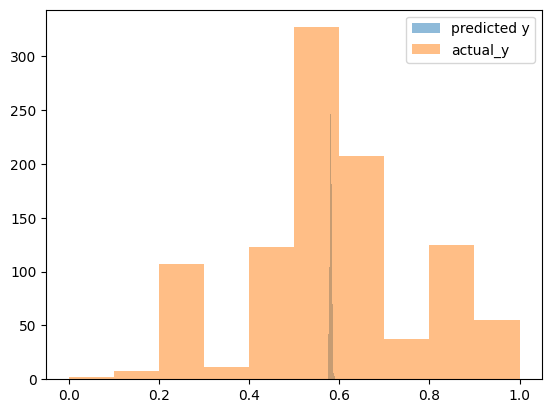

In [11]:
# Compare the predicted histogram of predicted vs. actual y values
plt.hist(pred_y, alpha=0.5, label='x')
plt.hist(test_y, alpha=0.5, label='y')
plt.legend(['predicted y', 'actual_y'], loc='upper right')
plt.show()